# FP-Growth

In [4]:
def transfer2FrozenDataSet(dataSet):
    frozenDataSet = {}
    for elem in dataSet:
        frozenDataSet[frozenset(elem)] = 1
    return frozenDataSet

class TreeNode:
    def __init__(self, nodeName, count, nodeParent):
        self.nodeName = nodeName
        self.count = count
        self.nodeParent = nodeParent
        self.nextSimilarItem = None
        self.children = {}

    def increaseC(self, count):
        self.count += count

def createFPTree(frozenDataSet, minSupport):
    #scan dataset at the first time, filter out items which are less than minSupport
    headPointTable = {}
    for items in frozenDataSet:
        for item in items:
            headPointTable[item] = headPointTable.get(item, 0) + frozenDataSet[items]
    headPointTable = {k:v for k,v in headPointTable.items() if v >= minSupport}
    frequentItems = set(headPointTable.keys())
    if len(frequentItems) == 0: return None, None

    for k in headPointTable:
        headPointTable[k] = [headPointTable[k], None]
    fptree = TreeNode("null", 1, None)
    #scan dataset at the second time, filter out items for each record
    for items,count in frozenDataSet.items():
        frequentItemsInRecord = {}
        for item in items:
            if item in frequentItems:
                frequentItemsInRecord[item] = headPointTable[item][0]
        if len(frequentItemsInRecord) > 0:
            orderedFrequentItems = [v[0] for v in sorted(frequentItemsInRecord.items(), key=lambda v:v[1], reverse = True)]
            updateFPTree(fptree, orderedFrequentItems, headPointTable, count)

    return fptree, headPointTable

def updateFPTree(fptree, orderedFrequentItems, headPointTable, count):
    #handle the first item
    if orderedFrequentItems[0] in fptree.children:
        fptree.children[orderedFrequentItems[0]].increaseC(count)
    else:
        fptree.children[orderedFrequentItems[0]] = TreeNode(orderedFrequentItems[0], count, fptree)

        #update headPointTable
        if headPointTable[orderedFrequentItems[0]][1] == None:
            headPointTable[orderedFrequentItems[0]][1] = fptree.children[orderedFrequentItems[0]]
        else:
            updateHeadPointTable(headPointTable[orderedFrequentItems[0]][1], fptree.children[orderedFrequentItems[0]])
    #handle other items except the first item
    if(len(orderedFrequentItems) > 1):
        updateFPTree(fptree.children[orderedFrequentItems[0]], orderedFrequentItems[1::], headPointTable, count)

def updateHeadPointTable(headPointBeginNode, targetNode):
    while(headPointBeginNode.nextSimilarItem != None):
        headPointBeginNode = headPointBeginNode.nextSimilarItem
    headPointBeginNode.nextSimilarItem = targetNode

def mineFPTree(headPointTable, prefix, frequentPatterns, minSupport):
    #for each item in headPointTable, find conditional prefix path, create conditional fptree, then iterate until there is only one element in conditional fptree
    headPointItems = [v[0] for v in sorted(headPointTable.items(), key = lambda v:v[1][0])]
    if(len(headPointItems) == 0): return

    for headPointItem in headPointItems:
        newPrefix = prefix.copy()
        newPrefix.add(headPointItem)
        support = headPointTable[headPointItem][0]
        frequentPatterns[frozenset(newPrefix)] = support

        prefixPath = getPrefixPath(headPointTable, headPointItem)
        if(prefixPath != {}):
            conditionalFPtree, conditionalHeadPointTable = createFPTree(prefixPath, minSupport)
            if conditionalHeadPointTable != None:
                mineFPTree(conditionalHeadPointTable, newPrefix, frequentPatterns, minSupport)

def getPrefixPath(headPointTable, headPointItem):
    prefixPath = {}
    beginNode = headPointTable[headPointItem][1]
    prefixs = ascendTree(beginNode)
    if((prefixs != [])):
        prefixPath[frozenset(prefixs)] = beginNode.count

    while(beginNode.nextSimilarItem != None):
        beginNode = beginNode.nextSimilarItem
        prefixs = ascendTree(beginNode)
        if (prefixs != []):
            prefixPath[frozenset(prefixs)] = beginNode.count
    return prefixPath

def ascendTree(treeNode):
    prefixs = []
    while((treeNode.nodeParent != None) and (treeNode.nodeParent.nodeName != 'null')):
        treeNode = treeNode.nodeParent
        prefixs.append(treeNode.nodeName)
    return prefixs

def rulesGenerator(frequentPatterns, minConf, rules):
    for frequentset in frequentPatterns:
        if(len(frequentset) > 1):
            getRules(frequentset,frequentset, rules, frequentPatterns, minConf)

def removeStr(set, str):
    tempSet = []
    for elem in set:
        if(elem != str):
            tempSet.append(elem)
    tempFrozenSet = frozenset(tempSet)
    return tempFrozenSet


def getRules(frequentset,currentset, rules, frequentPatterns, minConf):
    for frequentElem in currentset:
        subSet = removeStr(currentset, frequentElem)
        confidence = frequentPatterns[frequentset] / frequentPatterns[subSet]
        if (confidence >= minConf):
            flag = False
            for rule in rules:
                if(rule[0] == subSet and rule[1] == frequentset - subSet):
                    flag = True
            if(flag == False):
                rules.append((subSet, frequentset - subSet, confidence))

            if(len(subSet) >= 2):
                getRules(frequentset, subSet, rules, frequentPatterns, minConf)

def fpGrowth(dataSet, minSupport):
#     dataSet = pluno_merge
    frozenDataSet = transfer2FrozenDataSet(dataSet)
#     minSupport = 32
    fptree, headPointTable = createFPTree(frozenDataSet, minSupport)
    # fptree.disp()
    frequentPatterns = {}
    prefix = set([])
    mineFPTree(headPointTable, prefix, frequentPatterns, minSupport)
    print("frequent patterns:")
    for item in frequentPatterns:
        print(item, frequentPatterns[item])
    minConf = 0.6
    rules = []
#     rulesGenerator(frequentPatterns, minConf, rules)
#     print("association rules:")
#     for item in rules:
#         print(item)


# Load Data

In [5]:
import numpy as np
import pandas as pd
with open('./trade_new.csv', 'r') as resourse_data:
    data = pd.read_csv(resourse_data)[['vipno', 'sldatime', 'pluno', 'dptno', 'bndno']]
data['sldatime'] = pd.to_datetime(data['sldatime'])
data

,vipno,sldatime,pluno,dptno,bndno
0,2900003115009,2016-07-29 13:54:22,22002240,22002,NaN
1,2900001575201,2016-06-08 09:58:40,34150006,34150,34224.0
2,1591040161114,2016-02-24 16:07:08,11054040,11054,NaN
3,1591016439575,2016-05-21 18:09:33,27400855,27400,NaN
4,1591015027858,2016-04-03 15:45:23,11110121,11110,NaN
5,2900000476042,2016-07-23 18:46:14,15110032,15110,15039.0
6,1590140305107,2016-05-15 19:06:56,27400855,27400,NaN
7,2900000476042,2016-07-23 18:46:14,15110032,15110,15039.0
8,1590142197076,2016-05-24 10:42:04,27400855,27400,NaN
9,2900001436410,2016-06-13 17:19:08,15110032,15110,15039.0



#### i. 分别以pluno、dptno和bndno为频繁集挖掘的item_no，通过FP-Growth算法挖掘pluno、dptno和bndno的频繁集，其中要求support为2，4，8，16，32，64等共计6个阈值


In [6]:
sorted_vipno = data.sort_values(['sldatime'],ascending=True).groupby(['vipno', 'sldatime'])
pluno_slice = []
dptno_slice = []
bndno_slice = []
for x in sorted_vipno:
    length = int(len(x[1])*0.6)
    if length < 1:
        length = 1
    plu_temp = list(x[1]['pluno'].head(length))
    pluno_slice.append(plu_temp)
    dpt_temp = list(x[1]['dptno'].head(length))
    dptno_slice.append(dpt_temp)
    bnd_temp = list(x[1]['bndno'].head(length).dropna().astype(int))
    bndno_slice.append(bnd_temp)
# print(pluno_slice)
print(bndno_slice)

[[14350, 11129, 15094], [15094], [15094, 15052], [11288], [15631, 14436, 34001], [], [15009], [], [14319], [15012], [10068], [15012], [10684], [], [], [15012], [10721], [], [14354], [14366], [14794], [], [], [], [], [], [], [14158], [], [], [14545], [], [15590, 14330, 14268, 15094, 14268, 14330, 14330], [14651, 14651, 14651, 15012, 15009], [10706, 30248], [30248, 15009, 15009, 14035], [], [14435], [14362, 14366, 14357, 14160], [], [15012, 15083], [15052], [10045], [15012, 15012], [15012], [14355, 14355], [14333, 14338, 14338, 14333, 14333, 14366], [15092], [], [14333, 10082, 30248, 14333, 15039, 14333], [10062, 10082], [15045, 14357, 10082, 15083, 30248, 14319, 14333, 15038, 14333], [14652, 15012, 15012, 30248, 10063, 14558, 15039], [14333], [15631], [30248], [14267], [15052, 15094], [15094, 30248], [14338, 14160, 14338, 14545, 15012], [15012, 14098, 15649, 14723], [31129], [14623, 15012], [15094], [30793], [15094, 14350], [30248], [15012], [], [14475, 15012, 30248, 14102, 14281, 14281

In [7]:
while [] in bndno_slice:
    bndno_slice.remove([])
bndno_slice

[[14350, 11129, 15094],
 [15094],
 [15094, 15052],
 [11288],
 [15631, 14436, 34001],
 [15009],
 [14319],
 [15012],
 [10068],
 [15012],
 [10684],
 [15012],
 [10721],
 [14354],
 [14366],
 [14794],
 [14158],
 [14545],
 [15590, 14330, 14268, 15094, 14268, 14330, 14330],
 [14651, 14651, 14651, 15012, 15009],
 [10706, 30248],
 [30248, 15009, 15009, 14035],
 [14435],
 [14362, 14366, 14357, 14160],
 [15012, 15083],
 [15052],
 [10045],
 [15012, 15012],
 [15012],
 [14355, 14355],
 [14333, 14338, 14338, 14333, 14333, 14366],
 [15092],
 [14333, 10082, 30248, 14333, 15039, 14333],
 [10062, 10082],
 [15045, 14357, 10082, 15083, 30248, 14319, 14333, 15038, 14333],
 [14652, 15012, 15012, 30248, 10063, 14558, 15039],
 [14333],
 [15631],
 [30248],
 [14267],
 [15052, 15094],
 [15094, 30248],
 [14338, 14160, 14338, 14545, 15012],
 [15012, 14098, 15649, 14723],
 [31129],
 [14623, 15012],
 [15094],
 [30793],
 [15094, 14350],
 [30248],
 [15012],
 [14475, 15012, 30248, 14102, 14281, 14281, 14442, 14198, 14440

In [8]:
dptno_slice

[[14402, 11533, 11532, 15200],
 [11533, 11533, 15200],
 [15200, 15202],
 [11302],
 [15200, 14101, 34023],
 [22712],
 [15232],
 [22712],
 [14815],
 [15120],
 [10300],
 [15120],
 [10201],
 [27000],
 [23110],
 [15120],
 [10450],
 [23112],
 [14701],
 [14802],
 [14300],
 [27100],
 [22190],
 [22172, 23110],
 [22190],
 [22170, 22800],
 [22103, 27100, 22001, 23110],
 [14701],
 [22100],
 [24010, 22103],
 [22103, 14750, 22102, 22103],
 [27030, 22103, 27100],
 [15149, 14847, 14520, 15115, 14510, 14842, 14842],
 [14633, 14630, 14630, 15115, 15232],
 [10152, 27410, 30380, 22020],
 [24010, 30380, 27410, 15232, 15232, 14800],
 [27410, 20121],
 [25111, 27000, 25111, 14121, 25111, 27000],
 [14082, 20014, 14831, 24101, 14900, 25101, 14750],
 [22034],
 [23131, 21200, 22100, 15115, 23132, 23132, 15004, 22036],
 [11102, 11022, 15114],
 [10103, 22036],
 [22036, 15110, 15110],
 [22130, 27300, 23121, 21021, 15110, 27400, 22111],
 [22120, 14513, 14513, 27400],
 [14900, 14900, 14900, 14900, 14900, 14831],
 [274

In [9]:
pluno_slice

[[14402009, 11533012, 11532011, 15200007],
 [11533012, 11533012, 15200007],
 [15200007, 15202012],
 [11302032],
 [15200001, 14101028, 34023002],
 [22712001],
 [15232004],
 [22712001],
 [14815007],
 [15120003],
 [10300021],
 [15120003],
 [10201017],
 [27000582],
 [23110001],
 [15120006],
 [10450048],
 [23112032],
 [14701035],
 [14802054],
 [14300086],
 [27100542],
 [22190002],
 [22172004, 23110009],
 [22190000],
 [22170003, 22800001],
 [22103001, 27100542, 22001006, 23110009],
 [14701015],
 [22100010],
 [24010812, 22103005],
 [22103011, 14750062, 22102005, 22103005],
 [27030020, 22103006, 27100542],
 [15149000, 14847019, 14520008, 15115032, 14510003, 14842018, 14842022],
 [14633003, 14630008, 14630008, 15115000, 15232003],
 [10152022, 27410044, 30380003, 22020002],
 [24010809, 30380003, 27410044, 15232003, 15232003, 14800020],
 [27410000, 20121037],
 [25111045, 27000581, 25111045, 14121013, 25111045, 27000581],
 [14082026, 20014001, 14831034, 24101000, 14900021, 25101044, 14750041],
 [2

In [10]:
import time
pluno_runtime = []
dptno_runtime = []
bndno_runtime = []
support = [2, 4, 8, 16, 32, 64]

In [11]:
for i in support:
    start = time.clock()
    fpGrowth(pluno_slice, i)
    end = time.clock()
    pluno_runtime.append(end - start)

frequent patterns:
frozenset({14101028}) 2
frozenset({15120003}) 2
frozenset({22800001}) 2
frozenset({14750062}) 2
frozenset({14842018}) 2
frozenset({14842018, 14842022}) 2
frozenset({10152022}) 2
frozenset({14800020}) 2
frozenset({14121013}) 2
frozenset({14082026}) 2
frozenset({14750041}) 2
frozenset({14831034}) 2
frozenset({22034001}) 2
frozenset({11022054}) 2
frozenset({21021052}) 2
frozenset({14900006}) 2
frozenset({14916006}) 2
frozenset({14594025}) 2
frozenset({31003009}) 2
frozenset({14261001}) 2
frozenset({15115035}) 2
frozenset({14090008}) 2
frozenset({14090009}) 2
frozenset({14090013}) 2
frozenset({14800001}) 2
frozenset({11532022}) 2
frozenset({22000029}) 2
frozenset({27002438}) 2
frozenset({27000013}) 2
frozenset({14721018}) 2
frozenset({14261002}) 2
frozenset({23121051}) 2
frozenset({22034002}) 2
frozenset({15469025}) 2
frozenset({30447003}) 2
frozenset({22715004}) 2
frozenset({15502049}) 2
frozenset({14721080}) 2
frozenset({14814000}) 2
frozenset({24010825}) 2
frozenset({

frozenset({14822002}) 4
frozenset({14090021}) 4
frozenset({30380003, 14090021}) 2
frozenset({21012004}) 4
frozenset({34304010}) 4
frozenset({11056017}) 4
frozenset({14060006}) 4
frozenset({14084003}) 4
frozenset({14871000}) 4
frozenset({14871000, 30380003}) 2
frozenset({22008001}) 4
frozenset({14722022}) 4
frozenset({22671055}) 4
frozenset({11300191}) 4
frozenset({14802060}) 4
frozenset({14076017}) 4
frozenset({25150001}) 4
frozenset({10000025}) 4
frozenset({24102002}) 4
frozenset({14200035}) 4
frozenset({15110002}) 4
frozenset({27400048}) 4
frozenset({14091000}) 4
frozenset({14091000, 14092063}) 2
frozenset({14091000, 30380002}) 3
frozenset({15263006}) 4
frozenset({22500072}) 4
frozenset({14811002}) 4
frozenset({14811002, 30380002}) 2
frozenset({22160001}) 4
frozenset({14090007}) 4
frozenset({22103013}) 4
frozenset({30365021}) 4
frozenset({15114036}) 4
frozenset({30380003, 15114036}) 2
frozenset({10141048}) 4
frozenset({15502031}) 4
frozenset({22000031}) 4
frozenset({14111004}) 4
froz

frozenset({15232001}) 23
frozenset({15232001, 30380002}) 4
frozenset({22130000}) 24
frozenset({22130000, 15110001}) 2
frozenset({22130000, 22102014}) 2
frozenset({22130000, 22102004}) 2
frozenset({22130000, 22036000}) 2
frozenset({22130000, 27300274}) 2
frozenset({22130000, 30380003}) 2
frozenset({22130000, 22170001}) 3
frozenset({22130000, 25120016}) 3
frozenset({22101000}) 24
frozenset({22101000, 23110009}) 2
frozenset({22101000, 22102005}) 2
frozenset({22101000, 25120016}) 2
frozenset({22101000, 22102004}) 3
frozenset({22101000, 22036000}) 3
frozenset({22101000, 30380002}) 3
frozenset({22101000, 30380003}) 3
frozenset({22101000, 22111004}) 3
frozenset({22101000, 22111004, 22102014}) 2
frozenset({22101000, 22102014}) 6
frozenset({22701014}) 24
frozenset({23110001, 22701014}) 2
frozenset({23110009, 22701014}) 2
frozenset({27100542, 22701014}) 2
frozenset({30380003, 22701014}) 3
frozenset({30380002, 22701014}) 5
frozenset({22008019}) 25
frozenset({22008019, 22102005}) 2
frozenset({2311

frozenset({15130035}) 14
frozenset({23110006}) 14
frozenset({24101002}) 14
frozenset({22103005}) 15
frozenset({22130016}) 15
frozenset({22002240}) 15
frozenset({24101006}) 15
frozenset({27410002}) 15
frozenset({24010817}) 15
frozenset({27410005}) 15
frozenset({22030011}) 15
frozenset({14860017}) 15
frozenset({15231005}) 15
frozenset({22172007}) 15
frozenset({15130009}) 15
frozenset({22034026}) 15
frozenset({27410044}) 16
frozenset({23121052}) 16
frozenset({15110015}) 16
frozenset({24000373}) 16
frozenset({22021260}) 16
frozenset({22008012}) 16
frozenset({15110080}) 16
frozenset({24010809}) 17
frozenset({22013022}) 17
frozenset({27000576}) 17
frozenset({27000576, 30380002}) 4
frozenset({27000576, 27300273}) 5
frozenset({15202044}) 17
frozenset({22103004}) 17
frozenset({27300274, 22103004}) 4
frozenset({22020006}) 17
frozenset({22130017}) 17
frozenset({27300281}) 17
frozenset({27240000}) 17
frozenset({27300276}) 17
frozenset({22170001, 27300276}) 4
frozenset({23110009, 27300276}) 5
froze

frozenset({23110009, 30380003}) 19
frozenset({30380002}) 193
frozenset({30380003}) 335
frequent patterns:
frozenset({27000574}) 32
frozenset({27200924}) 32
frozenset({23110007}) 34
frozenset({15200007}) 35
frozenset({23120001}) 35
frozenset({22170001}) 36
frozenset({23134003}) 37
frozenset({27000581}) 38
frozenset({23131002}) 38
frozenset({15130027}) 39
frozenset({25101044}) 41
frozenset({22111004}) 41
frozenset({27100542}) 42
frozenset({25120016}) 49
frozenset({23110001}) 51
frozenset({27300274}) 56
frozenset({22102005}) 61
frozenset({22102014}) 67
frozenset({27410000}) 74
frozenset({22036000}) 86
frozenset({23110009}) 133
frozenset({30380002}) 193
frozenset({30380003}) 335
frequent patterns:
frozenset({22102014}) 67
frozenset({27410000}) 74
frozenset({22036000}) 86
frozenset({23110009}) 133
frozenset({30380002}) 193
frozenset({30380003}) 335


In [12]:
for i in support:
    start = time.clock()
    fpGrowth(bndno_slice, i)
    end = time.clock()
    bndno_runtime.append(end - start)

frequent patterns:
frozenset({10721}) 2
frozenset({14158}) 2
frozenset({31129}) 2
frozenset({14198}) 2
frozenset({14518}) 2
frozenset({10053}) 2
frozenset({10128}) 2
frozenset({14246}) 2
frozenset({10038}) 2
frozenset({15564}) 2
frozenset({30730}) 2
frozenset({30180}) 2
frozenset({30059}) 2
frozenset({34129}) 2
frozenset({14108}) 2
frozenset({11116}) 2
frozenset({11112}) 2
frozenset({14736}) 2
frozenset({14306}) 2
frozenset({11115}) 2
frozenset({30004}) 2
frozenset({30742}) 2
frozenset({11201}) 2
frozenset({14148}) 2
frozenset({30248, 14148}) 2
frozenset({11345}) 2
frozenset({14353}) 2
frozenset({14036}) 2
frozenset({11145}) 2
frozenset({32183}) 2
frozenset({14461}) 2
frozenset({14650, 14461}) 2
frozenset({14779}) 2
frozenset({14767}) 2
frozenset({11152}) 2
frozenset({14832}) 2
frozenset({14832, 15012}) 2
frozenset({14786}) 2
frozenset({14738}) 2
frozenset({14661}) 2
frozenset({14661, 15094}) 2
frozenset({11375}) 2
frozenset({14039}) 2
frozenset({15010}) 2
frozenset({30039}) 2
frozense

frozenset({14098, 14333}) 2
frozenset({14338, 14333}) 4
frozenset({30248, 14333}) 6
frozenset({14372}) 17
frozenset({14810, 14372}) 2
frozenset({30248, 14372}) 2
frozenset({14372, 15094}) 2
frozenset({14372, 14622}) 3
frozenset({10124}) 17
frozenset({14322, 10124}) 2
frozenset({10124, 15094}) 2
frozenset({14281, 10124}) 2
frozenset({30248, 10124}) 4
frozenset({14678}) 17
frozenset({14177, 14678}) 2
frozenset({15012, 14678}) 2
frozenset({14678, 15631}) 2
frozenset({15045, 14678}) 2
frozenset({15066, 14678}) 3
frozenset({15009, 14678}) 3
frozenset({15038, 14678}) 3
frozenset({15009, 15038, 14678}) 2
frozenset({15066, 15038, 14678}) 2
frozenset({30248, 14678}) 4
frozenset({15094, 14678}) 4
frozenset({30216}) 17
frozenset({30216, 14810}) 2
frozenset({30216, 15094}) 3
frozenset({30216, 30248, 15094}) 2
frozenset({30216, 30248}) 7
frozenset({14051}) 17
frozenset({14281, 14051}) 2
frozenset({14177, 14051}) 2
frozenset({15009, 14051}) 3
frozenset({30248, 14051}) 6
frozenset({14213}) 17
frozens

frozenset({15078}) 11
frozenset({11159}) 11
frozenset({15026}) 11
frozenset({10719}) 11
frozenset({10659}) 12
frozenset({30248, 10659}) 5
frozenset({14191}) 12
frozenset({14509}) 12
frozenset({14079}) 12
frozenset({14126}) 12
frozenset({15632}) 12
frozenset({15632, 30248}) 4
frozenset({15577}) 12
frozenset({10069}) 12
frozenset({30248, 10069}) 4
frozenset({11385}) 12
frozenset({15073}) 12
frozenset({30248, 15073}) 4
frozenset({15073, 15009}) 4
frozenset({14189}) 12
frozenset({15057}) 12
frozenset({15001}) 12
frozenset({15001, 15052}) 4
frozenset({30248, 15001}) 4
frozenset({14544}) 12
frozenset({14544, 30248}) 4
frozenset({14445}) 12
frozenset({14281, 14445}) 4
frozenset({14350}) 13
frozenset({14350, 15039}) 4
frozenset({14651}) 13
frozenset({30833}) 13
frozenset({30248, 30833}) 5
frozenset({14032}) 13
frozenset({14032, 30248}) 7
frozenset({14258}) 13
frozenset({14322, 14258}) 4
frozenset({30248, 14258}) 7
frozenset({14231}) 13
frozenset({11154}) 14
frozenset({30248, 11154}) 5
frozense

frequent patterns:
frozenset({10045}) 16
frozenset({14168}) 16
frozenset({10080}) 16
frozenset({14333}) 17
frozenset({14372}) 17
frozenset({10124}) 17
frozenset({14678}) 17
frozenset({30216}) 17
frozenset({14051}) 17
frozenset({14213}) 17
frozenset({14268}) 18
frozenset({10007}) 18
frozenset({15067}) 18
frozenset({11129}) 19
frozenset({14330}) 19
frozenset({15590}) 19
frozenset({10062}) 19
frozenset({15045}) 19
frozenset({15123}) 19
frozenset({14313}) 20
frozenset({10211}) 20
frozenset({14319}) 21
frozenset({10068}) 21
frozenset({14160}) 21
frozenset({14208}) 21
frozenset({14265}) 22
frozenset({14082}) 23
frozenset({15083}) 24
frozenset({10060}) 25
frozenset({14173}) 25
frozenset({15011}) 27
frozenset({14338}) 28
frozenset({14810}) 28
frozenset({10106}) 29
frozenset({14794}) 30
frozenset({15038}) 30
frozenset({14281}) 30
frozenset({14475}) 31
frozenset({30170}) 31
frozenset({14362}) 32
frozenset({15060}) 32
frozenset({14098}) 33
frozenset({14366}) 36
frozenset({14442}) 37
frozenset({30

In [13]:
for i in support:
    start = time.clock()
    fpGrowth(dptno_slice, i)
    end = time.clock()
    dptno_runtime.append(end - start)

frequent patterns:
frozenset({34023}) 2
frozenset({14510}) 2
frozenset({14256}) 2
frozenset({30445}) 2
frozenset({34200}) 2
frozenset({30903}) 2
frozenset({22902}) 2
frozenset({11500, 22902}) 2
frozenset({11501, 22902}) 2
frozenset({11500, 11501, 22902}) 2
frozenset({30380, 22902}) 2
frozenset({14220}) 2
frozenset({30011}) 2
frozenset({22860}) 2
frozenset({24111}) 2
frozenset({30810}) 2
frozenset({15123}) 2
frozenset({15100}) 2
frozenset({11111}) 2
frozenset({30451}) 2
frozenset({15432}) 2
frozenset({11114}) 2
frozenset({30231}) 2
frozenset({32315}) 2
frozenset({30600}) 2
frozenset({36022}) 2
frozenset({23110, 36022}) 2
frozenset({32403}) 2
frozenset({14014}) 2
frozenset({11210}) 2
frozenset({22851}) 2
frozenset({14663}) 2
frozenset({32352}) 2
frozenset({14506}) 2
frozenset({14506, 23110}) 2
frozenset({11313}) 2
frozenset({31023}) 2
frozenset({14650}) 2
frozenset({30133}) 2
frozenset({32110}) 2
frozenset({11100}) 2
frozenset({36010}) 2
frozenset({14827}) 2
frozenset({30515}) 2
frozense

frozenset({14105, 30380, 14092}) 2
frozenset({14105, 30380, 14091, 14092}) 2
frozenset({14105, 14750}) 2
frozenset({14105, 14101}) 2
frozenset({14105, 23134}) 2
frozenset({14105, 15115}) 4
frozenset({14105, 15115, 30380}) 4
frozenset({14105, 30380}) 6
frozenset({14033}) 12
frozenset({14033, 15114}) 2
frozenset({14033, 14082}) 2
frozenset({14200, 14033}) 2
frozenset({14033, 23110}) 3
frozenset({14033, 30380, 23110}) 2
frozenset({14033, 30380}) 4
frozenset({14822}) 12
frozenset({14800, 14822}) 2
frozenset({14822, 14815}) 2
frozenset({14822, 15110}) 2
frozenset({30380, 14822, 15110}) 2
frozenset({30380, 14822}) 3
frozenset({15235}) 12
frozenset({15235, 15110}) 2
frozenset({15235, 30380}) 3
frozenset({10109}) 12
frozenset({15130, 10109}) 2
frozenset({15130, 30380, 10109}) 2
frozenset({14080, 10109}) 2
frozenset({14080, 30380, 10109}) 2
frozenset({14092, 10109}) 2
frozenset({10109, 10119}) 3
frozenset({30380, 10109}) 6
frozenset({14513}) 13
frozenset({14513, 15115}) 2
frozenset({22171}) 13


frozenset({22030, 22111}) 2
frozenset({24000, 22030, 22111}) 2
frozenset({22701, 22030}) 3
frozenset({30380, 22701, 22030}) 2
frozenset({22036, 22030}) 4
frozenset({22030, 15110}) 5
frozenset({30380, 22030}) 7
frozenset({14130}) 28
frozenset({14130, 15130}) 2
frozenset({10000, 14130}) 2
frozenset({14130, 14076}) 2
frozenset({24010, 14130}) 2
frozenset({14130, 10119}) 2
frozenset({14130, 30380, 10119}) 2
frozenset({14130, 15115}) 2
frozenset({14130, 15119}) 2
frozenset({14130, 23110}) 2
frozenset({14130, 14090}) 3
frozenset({15232, 14130}) 3
frozenset({14130, 15004}) 3
frozenset({14130, 11532}) 3
frozenset({14200, 14130}) 3
frozenset({14130, 14092}) 3
frozenset({14130, 14090, 14092}) 2
frozenset({30380, 14130, 14092}) 2
frozenset({14130, 15110}) 4
frozenset({14130, 30380}) 8
frozenset({15242}) 28
frozenset({15232, 15242}) 2
frozenset({15232, 15242, 15202}) 2
frozenset({15242, 27300}) 2
frozenset({15242, 15119}) 2
frozenset({14721, 15242}) 2
frozenset({15242, 15004}) 2
frozenset({15242, 

frozenset({30380, 24101, 22103}) 2
frozenset({24101, 22111, 22103}) 2
frozenset({30380, 24101, 22111, 22103}) 2
frozenset({23132, 24101}) 3
frozenset({23113, 23132, 24101}) 2
frozenset({24101, 22102}) 3
frozenset({24101, 22102, 22111}) 2
frozenset({24101, 15110}) 3
frozenset({27000, 24101}) 3
frozenset({27000, 30380, 24101}) 2
frozenset({27000, 24101, 23110}) 2
frozenset({27000, 30380, 24101, 23110}) 2
frozenset({22172, 24101}) 3
frozenset({15130, 24101}) 4
frozenset({27002, 24101}) 4
frozenset({23113, 24101}) 4
frozenset({24101, 23110}) 4
frozenset({30380, 24101, 23110}) 2
frozenset({24101, 22111}) 7
frozenset({30380, 24101, 22111}) 2
frozenset({30380, 24101}) 8
frozenset({15119}) 45
frozenset({27300, 15119}) 2
frozenset({27300, 23110, 15119}) 2
frozenset({15202, 15119}) 2
frozenset({27000, 15119}) 2
frozenset({23132, 15119}) 2
frozenset({27002, 23132, 15119}) 2
frozenset({27400, 15119}) 2
frozenset({24010, 15119}) 2
frozenset({22102, 15119}) 2
frozenset({27410, 22102, 15119}) 2
froze

frozenset({27002, 27410, 30380}) 3
frozenset({27000, 27002}) 14
frozenset({27000, 27002, 30380}) 2
frozenset({27002, 23110}) 17
frozenset({27002, 30380, 23110}) 4
frozenset({27002, 30380}) 26
frozenset({27300}) 137
frozenset({27300, 15110}) 7
frozenset({27300, 22102}) 13
frozenset({30380, 27300, 22102}) 3
frozenset({27000, 27300}) 15
frozenset({27000, 30380, 27300}) 3
frozenset({27410, 27300}) 15
frozenset({30380, 27410, 27300}) 3
frozenset({30380, 27410, 27300, 27000}) 2
frozenset({27000, 27410, 27300}) 6
frozenset({27300, 23110}) 20
frozenset({30380, 27300, 23110}) 3
frozenset({30380, 27300}) 29
frozenset({27000}) 138
frozenset({27000, 22102}) 8
frozenset({27000, 30380, 22102}) 2
frozenset({27000, 15110}) 9
frozenset({27000, 30380, 15110}) 2
frozenset({27000, 23110, 15110}) 2
frozenset({27000, 23110, 30380, 15110}) 2
frozenset({27000, 23110}) 12
frozenset({27000, 30380, 23110}) 5
frozenset({27000, 27410}) 16
frozenset({27000, 27410, 30380}) 6
frozenset({27000, 30380}) 33
frozenset({2

frozenset({14052}) 22
frozenset({14052, 14092}) 4
frozenset({30380, 14052}) 9
frozenset({22000}) 23
frozenset({22000, 23110}) 4
frozenset({22000, 30380}) 7
frozenset({22007}) 23
frozenset({30380, 22007}) 4
frozenset({14000}) 23
frozenset({14000, 30380}) 4
frozenset({14000, 15130}) 4
frozenset({22002}) 24
frozenset({22002, 30380}) 4
frozenset({22002, 15110}) 5
frozenset({15502}) 24
frozenset({23110, 15502}) 4
frozenset({15115, 15502}) 5
frozenset({30380, 15502}) 5
frozenset({15502, 15110}) 5
frozenset({10130}) 24
frozenset({14300}) 25
frozenset({14091, 14300}) 4
frozenset({14300, 23110}) 5
frozenset({30380, 14300}) 7
frozenset({11501}) 25
frozenset({11500, 11501}) 9
frozenset({30380, 11500, 11501}) 5
frozenset({30380, 11501}) 11
frozenset({11533}) 26
frozenset({30380, 11533}) 4
frozenset({27000, 11533}) 4
frozenset({11533, 10141}) 4
frozenset({21801}) 26
frozenset({21801, 15110}) 4
frozenset({21801, 30380}) 8
frozenset({22601}) 26
frozenset({22601, 22102}) 4
frozenset({22601, 27410}) 4


frozenset({25012}) 11
frozenset({14034}) 11
frozenset({15149}) 12
frozenset({10152}) 12
frozenset({10152, 30380}) 8
frozenset({10137}) 12
frozenset({15410}) 12
frozenset({14834}) 12
frozenset({14140}) 12
frozenset({15140}) 12
frozenset({15605}) 12
frozenset({25130}) 12
frozenset({14105}) 12
frozenset({14033}) 12
frozenset({14822}) 12
frozenset({15235}) 12
frozenset({10109}) 12
frozenset({14513}) 13
frozenset({22171}) 13
frozenset({20110}) 13
frozenset({25100}) 13
frozenset({10151}) 13
frozenset({14241}) 13
frozenset({14073}) 13
frozenset({15139}) 13
frozenset({14021}) 13
frozenset({14846}) 13
frozenset({14121}) 14
frozenset({14050}) 14
frozenset({11230}) 14
frozenset({14131}) 14
frozenset({10131}) 14
frozenset({14132}) 14
frozenset({14841}) 14
frozenset({14800}) 15
frozenset({25121}) 15
frozenset({14812}) 15
frozenset({15113}) 15
frozenset({14844}) 15
frozenset({14112}) 15
frozenset({15263}) 15
frozenset({10310}) 15
frozenset({11531}) 15
frozenset({14837}) 15
frozenset({14101}) 16
froz

frequent patterns:
frozenset({22172}) 65
frozenset({25101}) 65
frozenset({15200}) 67
frozenset({27400}) 68
frozenset({14092}) 69
frozenset({27200}) 70
frozenset({14091}) 71
frozenset({15202}) 74
frozenset({23132}) 75
frozenset({15114}) 78
frozenset({22130}) 80
frozenset({25120}) 80
frozenset({10141}) 81
frozenset({22036}) 87
frozenset({22103}) 95
frozenset({22008}) 95
frozenset({24010}) 98
frozenset({15115}) 107
frozenset({22111}) 109
frozenset({15130}) 116
frozenset({27002}) 116
frozenset({27300}) 137
frozenset({27000}) 138
frozenset({27410}) 152
frozenset({22102}) 164
frozenset({15110}) 216
frozenset({23110}) 252
frozenset({30380, 23110}) 66
frozenset({30380}) 528


In [14]:
import matplotlib.pyplot as plt

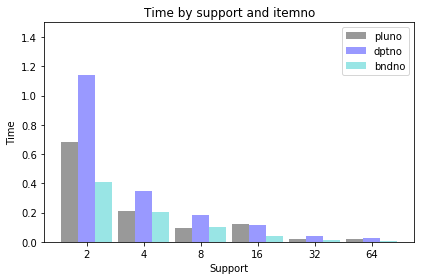

In [18]:
n_groups = len(support)

fig, ax = plt.subplots()    
index = np.arange(n_groups)    
bar_width = 0.3  
         
opacity = 0.4    
rects1 = plt.bar(index, pluno_runtime, bar_width,alpha=opacity, color='k',label=    'pluno')    
rects2 = plt.bar(index + bar_width, dptno_runtime, bar_width,alpha=opacity,color='b',label='dptno')    
rects2 = plt.bar(index + bar_width * 2, bndno_runtime, bar_width,alpha=opacity,color='c',label='bndno')    

plt.xlabel('Support')    
plt.ylabel('Time')    
plt.title('Time by support and itemno')    
plt.xticks(index + bar_width, support)    
plt.ylim(0, 1.5);    
plt.legend();    
      
plt.tight_layout();   
plt.show();